# Proyek Klasifikasi Gambar: Animal -5 Mammal
- **Nama:** Muhammad Farkhan Adhitama
- **Email:** mfarkhan62@gmail.com
- **ID Dicoding:** farkhan_adhit

## Import Semua Packages/Library yang Digunakan

In [1]:
# Library yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

In [2]:
# Libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

In [3]:
# Libraries untuk pembangunan model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.19.0


In [4]:
!pip install tensorflowjs

## Data Preparation

### Data Loading

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"muhammadfarkhana","key":"9accf881e846baba2ba3c3e825e33cde"}'}

In [ ]:
!pip install kagglehub
import kagglehub

**Insight :**  Dataset berisi citra hewan berkualitas sedang dalam 5 kategori: anjing, kucing, kuda, gajah, singa. Semua gambar telah dikumpulkan dari "google images" dan telah diperiksa oleh manusia. Ada beberapa data yang salah untuk mensimulasikan kondisi nyata,

In [ ]:
# donwload dataset dari kaggle dan letakkan dalam folder mammal image classification
!kaggle datasets download -d shiv28/animal-5-mammal
!unzip animal-5-mammal.zip -d animal-5-mammal

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: animal-5-mammal/Animal/train/cat/pixabay_cat_003879.jpg  
  inflating: animal-5-mammal/Animal/train/cat/pixabay_cat_003880.jpg  
  inflating: animal-5-mammal/Animal/train/cat/pixabay_cat_003881.jpg  
  inflating: animal-5-mammal/Animal/train/cat/pixabay_cat_003882.jpg  
  inflating: animal-5-mammal/Animal/train/cat/pixabay_cat_003883.jpg  
  inflating: animal-5-mammal/Animal/train/cat/pixabay_cat_003884.jpg  
  inflating: animal-5-mammal/Animal/train/cat/pixabay_cat_003885.jpg  
  inflating: animal-5-mammal/Animal/train/cat/pixabay_cat_003886.jpg  
  inflating: animal-5-mammal/Animal/train/cat/pixabay_cat_003887.jpg  
  inflating: animal-5-mammal/Animal/train/cat/pixabay_cat_003888.jpg  
  inflating: animal-5-mammal/Animal/train/cat/pixabay_cat_003889.jpg  
  inflating: animal-5-mammal/Animal/train/cat/pixabay_cat_003891.jpg  
  inflating: animal-5-mammal/Animal/train/cat/pixabay_cat_003892.jpg  
  inflating: anima

In [ ]:
# Salin dataset ke folder animals-dataset-final
source_dir = "/content/animal-5-mammal/Animal/train"  # Folder asal
destination_dir = "animals-dataset-final"  # Folder tujuan
os.makedirs(destination_dir, exist_ok=True)

# Loop melalui setiap subfolder dalam train
for class_name in os.listdir(source_dir):
    source_path = os.path.join(source_dir, class_name)
    destination_path = os.path.join(destination_dir, class_name)
    if os.path.isdir(source_path):
        # Salin folder dan isinya ke dalam dataset-final
        shutil.copytree(source_path, destination_path, dirs_exist_ok=True)

print("Penyalinan selesai!")

Penyalinan selesai!


In [ ]:
# Buat tabel path data dan labelnya
data_dir = '/content/animals-dataset-final'
filepaths = []
labels = []

In [ ]:
# Ambil datapath dan nama folder sebagai labelnya
folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

In [ ]:
path_img = pd.Series(filepaths, name= 'filepaths')
label_img = pd.Series(labels, name='labels')
df = pd.concat([path_img, label_img], axis= 1)

In [ ]:
df.head()

,filepaths,labels
0,/content/animals-dataset-final/HORSE/G47QS615P...,HORSE
1,/content/animals-dataset-final/HORSE/Q6LB4ZLCJ...,HORSE
2,/content/animals-dataset-final/HORSE/Img-657.jpg,HORSE
3,/content/animals-dataset-final/HORSE/images170...,HORSE
4,/content/animals-dataset-final/HORSE/Img-12555...,HORSE


In [ ]:
# Jumlah data : 13711 data gamba
df.shape

(13497, 2)

In [ ]:
# Jumlah gambar pada tiap kelas sea animals
df.groupby('labels').count().T

labels,ELEPHANT,HORSE,LION,cat,dog
filepaths,2740,2709,2684,2737,2627


# Data Visualization

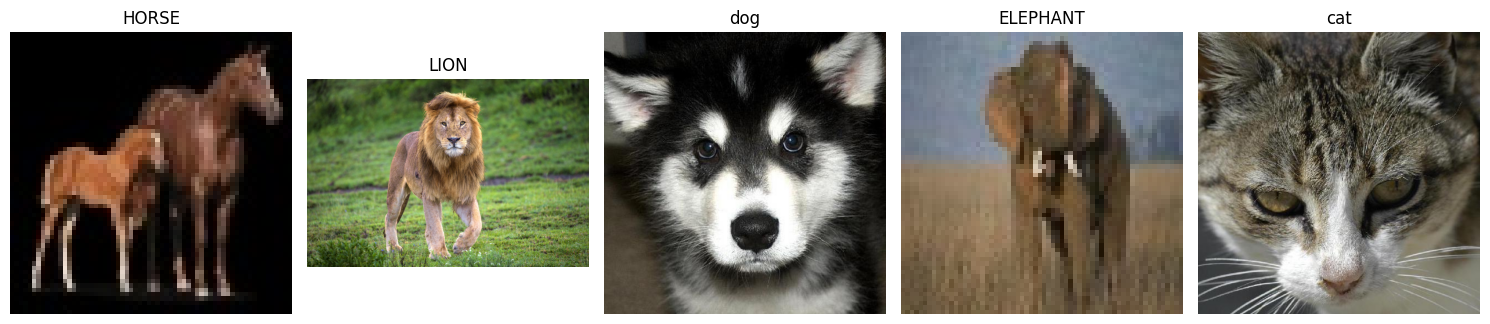

In [ ]:
# Cek gambar pada dataset
import matplotlib.pyplot as plt
import random

# Ambil gambar pertama dari setiap kelas unik
unique_classes = list(set(labels))
selected_images = {}

for filepath, label in zip(filepaths, labels):
    if label not in selected_images:
        selected_images[label] = filepath
    if len(selected_images) == 10:
        break

# Tampilkan gambar
fig, axes = plt.subplots(1, 5, figsize=(15, 6))  # Grid 2x5
for ax, (label, img_path) in zip(axes.flat, selected_images.items()):
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(label)
    ax.axis("off")
plt.tight_layout()
plt.show()

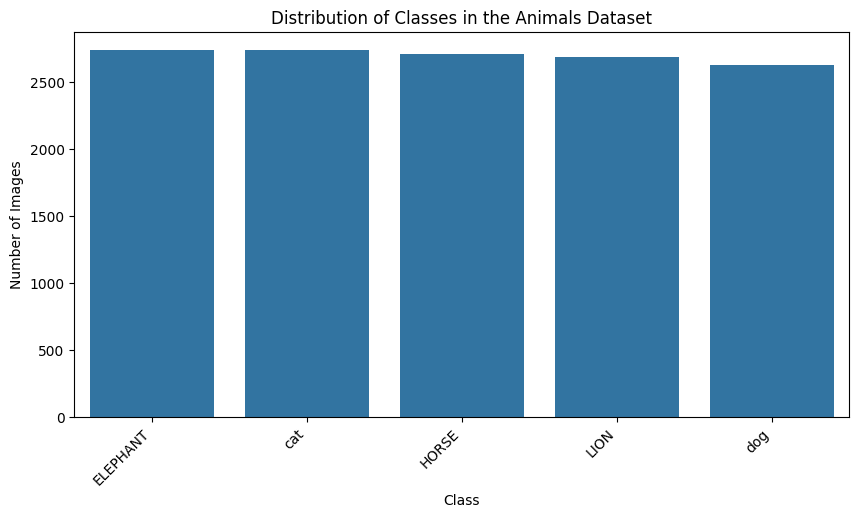

In [ ]:
import seaborn as sns
from collections import Counter

class_counts = Counter(labels)
df_counts = pd.DataFrame(class_counts.items(), columns=["Class", "Count"])
df_counts = df_counts.sort_values(by="Count", ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x="Class", y="Count", data=df_counts)
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Distribution of Classes in the Animals Dataset")
plt.xticks(rotation=45, ha="right")  # Rotasi label sumbu X
plt.show()

### Data Preprocessing

#### Split Dataset

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Split dataset: 80% train, 20% (akan dibagi lagi jadi val dan test)
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['labels'], random_state=42)

# Split sisa 20% menjadi 10% val dan 10% test (50:50 dari temp_df)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['labels'], random_state=42)


In [ ]:
print("Jumlah gambar per kelas di Training Set:")
print(train_df['labels'].value_counts())

print("\nJumlah gambar per kelas di Validation Set:")
print(val_df['labels'].value_counts())

print("\nJumlah gambar per kelas di Test Set:")
print(test_df['labels'].value_counts())

Jumlah gambar per kelas di Training Set:
labels
ELEPHANT    2192
cat         2189
HORSE       2167
LION        2147
dog         2102
Name: count, dtype: int64

Jumlah gambar per kelas di Validation Set:
labels
ELEPHANT    274
cat         274
HORSE       271
LION        268
dog         263
Name: count, dtype: int64

Jumlah gambar per kelas di Test Set:
labels
cat         274
ELEPHANT    274
HORSE       271
LION        269
dog         262
Name: count, dtype: int64


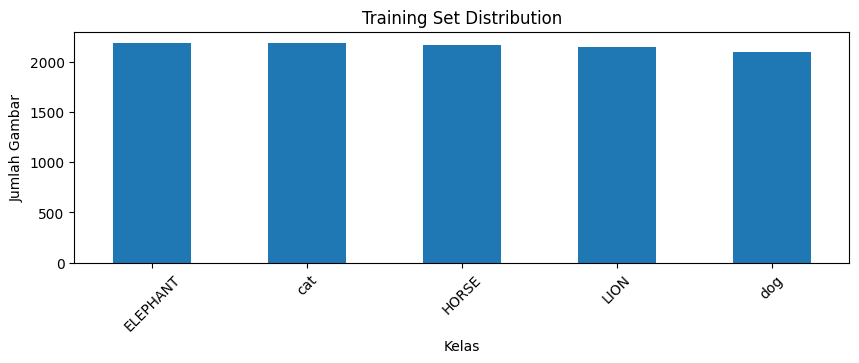

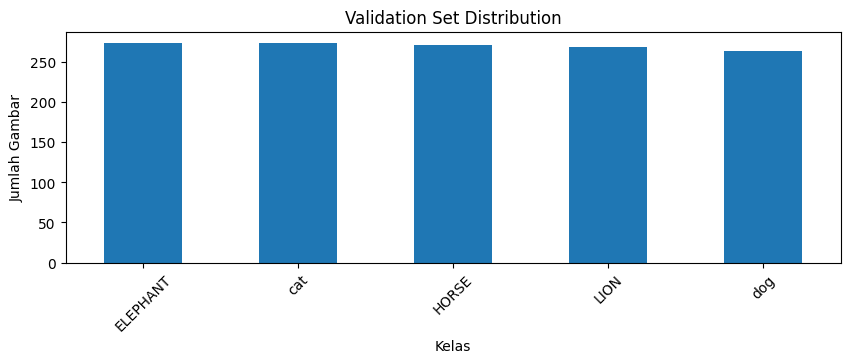

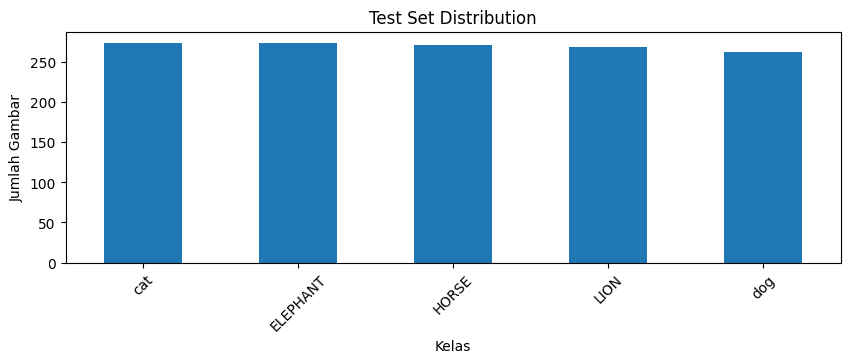

In [ ]:
import matplotlib.pyplot as plt

def plot_class_distribution(df, title):
    class_counts = df['labels'].value_counts()
    plt.figure(figsize=(10, 3))
    class_counts.plot(kind='bar')
    plt.title(title)
    plt.xlabel("Kelas")
    plt.ylabel("Jumlah Gambar")
    plt.xticks(rotation=45)
    plt.show()

plot_class_distribution(train_df, "Training Set Distribution")
plot_class_distribution(val_df, "Validation Set Distribution")
plot_class_distribution(test_df, "Test Set Distribution")

In [ ]:
# ImageDataGenerator untuk augmentasi dan normalisasi
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=30, width_shift_range=0.2,
                                   height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
                                   horizontal_flip=True, fill_mode='nearest')

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Load data menggunakan flow_from_dataframe
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 10796 validated image filenames belonging to 5 classes.
Found 1350 validated image filenames belonging to 5 classes.
Found 1350 validated image filenames belonging to 5 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn(


## Modelling

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(128, 128, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(train_generator.class_indices), activation='softmax'))  # Output sesuai jumlah kelas

model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)                   │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 8, 8, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 8, 8, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,837,765 (7.01 MB)

 Trainable params: 1,835,781 (7.00 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Buat callback, berhenti training jika akurasi di atas 95%
class StopTrainingAtAccuracy(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        train_acc = logs.get("accuracy")

        if train_acc is not None:
            if train_acc > 0.95 :
                print(f"\n🔴 Training dihentikan pada epoch {epoch+1}: Akurasi Train = {train_acc:.4f}")
                self.model.stop_training = True

# Tambahkan callback ini saat training
stop_callback = StopTrainingAtAccuracy()

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    epochs=100,
    batch_size=32,
    validation_data=val_generator,
    callbacks=[stop_callback]
)

Epoch 1/100
338/338 ━━━━━━━━━━━━━━━━━━━━ 79s 213ms/step - accuracy: 0.4123 - loss: 1.6242 - val_accuracy: 0.1985 - val_loss: 3.6537
Epoch 2/100
338/338 ━━━━━━━━━━━━━━━━━━━━ 68s 202ms/step - accuracy: 0.6652 - loss: 0.8479 - val_accuracy: 0.6237 - val_loss: 1.1129
Epoch 3/100
338/338 ━━━━━━━━━━━━━━━━━━━━ 67s 200ms/step - accuracy: 0.7586 - loss: 0.6193 - val_accuracy: 0.6778 - val_loss: 0.9570
Epoch 4/100
338/338 ━━━━━━━━━━━━━━━━━━━━ 68s 201ms/step - accuracy: 0.8003 - loss: 0.5210 - val_accuracy: 0.7659 - val_loss: 0.6444
Epoch 5/100
338/338 ━━━━━━━━━━━━━━━━━━━━ 67s 198ms/step - accuracy: 0.8365 - loss: 0.4326 - val_accuracy: 0.7244 - val_loss: 1.0335
Epoch 6/100
338/338 ━━━━━━━━━━━━━━━━━━━━ 67s 200ms/step - accuracy: 0.8517 - loss: 0.4024 - val_accuracy: 0.6881 - val_loss: 1.1317
Epoch 7/100
338/338 ━━━━━━━━━━━━━━━━━━━━ 67s 198ms/step - accuracy: 0.8591 - loss: 0.3782 - val_accuracy: 0.8615 - val_loss: 0.3651
Epoch 8/100
338/338 ━━━━━━━━━━━━━━━━━━━━ 68s 200ms/step - accuracy: 0.8670 -

## Evaluasi dan Visualisasi

### Visualisasi Training dan Validasi

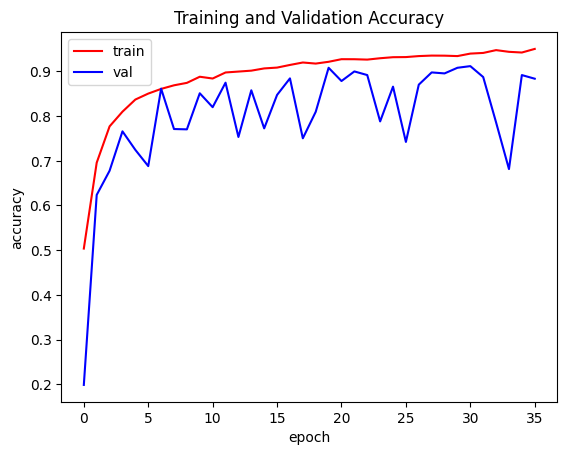

In [ ]:
# Training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(acc))
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

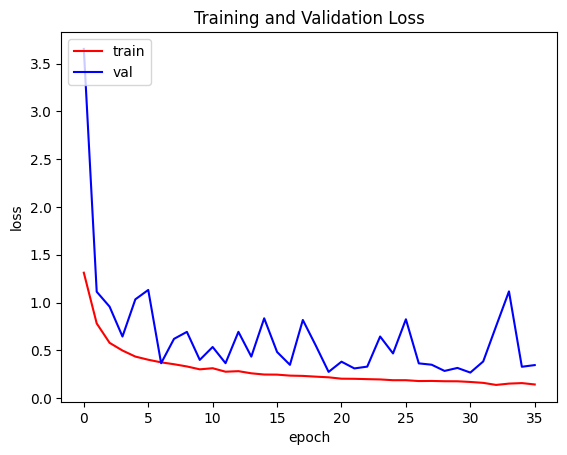

In [ ]:
# Training and Validation Loss
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validation Loss')
plt.show()

### Evaluasi Data Testing

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - accuracy: 0.8819 - loss: 0.4042
Test Accuracy: 88.15%
Test Loss: 0.3809


**Kesimpulan :** Dari hasil testing yang dilakukan, dicapai Test Accuracy: 88.15% dan Test Loss: 0.3809. Hasil akurasi sebesar 88% cukup bagus untuk model klasifikasi gambar. Sangat sulit untuk mencapai hasil testing 95 persen ke atas, tolong didiskusikan mengenai syarat penilaian tugas.

## Konversi Model

## SavedModel

In [ ]:
save_path = 'mymodel/'
tf.saved_model.save(model, save_path)

Cause: Unable to locate the source code of <function TFLayer._default_save_signature.<locals>.serving_default at 0x7bcb66876020>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function TFLayer._default_save_signature.<locals>.serving_default at 0x7bcb66876020>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function TFLayer._default_save_signature.<locals>.serving_default at 0x7bcb66877920>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function TFLayer._default_save_signature.<locals>.serving_default at 0x7bcb66877920>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


## TF lite

In [ ]:
model.save('my_model.h5')

In [ ]:
model = tf.keras.models.load_model("my_model.h5")
converter = tf.lite.TFLiteConverter.from_keras_model(model)

tflite_model = converter.convert()
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model berhasil dikonversi ke TensorFlow Lite!")

Saved artifact at '/tmp/tmpq_60hesf'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='input_layer_3')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  136115434900368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136115434904208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136115434901328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136115434910928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136115434900752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136115434907088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136115434907856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136115434905936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136115434913232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136115434906704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1361154349088

## TFJS

In [6]:
!tensorflowjs_converter --input_format=keras /content/my_model.h5 /content/my_model_tfjs

2025-03-17 05:37:39.572247: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742189859.598269    4150 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742189859.605767    4150 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742189859.625449    4150 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742189859.625502    4150 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742189859.625507    4150 computation_placer.cc:177] computation placer alr

## Inference (Optional)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Ambil batch pertama dari test_datagen
batch_images, batch_labels = next(test_generator)  # Ambil batch pertama
num_samples = 5
sample_images = batch_images[:num_samples]
sample_labels = batch_labels[:num_samples]

In [ ]:
# Prediksi menggunakan model
predictions = model.predict(sample_images)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(sample_labels, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


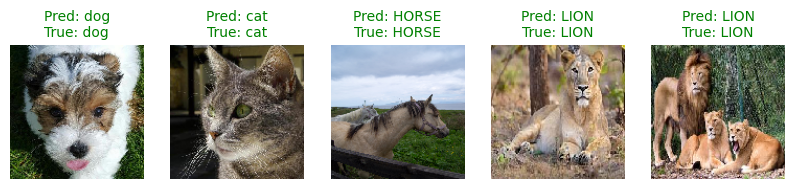

In [ ]:
# Ambil daftar kelas dari test_generator
class_indices = test_generator.class_indices
class_labels = list(class_indices.keys())
plt.figure(figsize=(10, 5))
for i in range(num_samples):
    plt.subplot(1, num_samples, i+1)
    plt.imshow(sample_images[i])
    plt.axis('off')
    # Tampilkan prediksi & label sebenarnya
    pred_label = class_labels[predicted_classes[i]]
    true_label = class_labels[true_classes[i]]
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}", fontsize=10, color=("green" if pred_label == true_label else "red"))
plt.show()